Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Se normalizaron los datos manualmente con pytorch

In [2]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [3]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [4]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [5]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

# Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()
#Probemos normalizar los datos
ShanghaiDat = torch.tensor(ShanghaiDat, dtype=torch.float32)
mean = ShanghaiDat.mean()
std = ShanghaiDat.std()
ShanghaiDat = (ShanghaiDat - mean) / std
ShanghaiDat = ShanghaiDat.numpy() 


#Dividimos en epocas de 10 dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [6]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [7]:
# Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512):
        super(TransformerModel, self).__init__() 
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(input_size * sequence_length, 1)

    def forward(self, src):
        src = src.reshape(-1, self.sequence_length, 1) 
        src = src.flatten(start_dim=1) 
        src = src.unsqueeze(0) 
        out = self.transformer_encoder(src) 
        out = out.squeeze(0) 
        return self.fc_out(out) 

In [8]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

# Training loop
losses=[]
for epoch in range(300):
    for seq, next_point in dataloader:
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) 
        output = model(seq)
        loss = criterion(output, next_point) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.22452086210250854
Epoch 2, Loss: 0.10932069271802902
Epoch 3, Loss: 0.0646110475063324
Epoch 4, Loss: 0.033413734287023544
Epoch 5, Loss: 0.06982937455177307
Epoch 6, Loss: 0.042815811932086945
Epoch 7, Loss: 0.05201161280274391
Epoch 8, Loss: 0.023603100329637527
Epoch 9, Loss: 0.02407413348555565
Epoch 10, Loss: 0.03301013633608818
Epoch 11, Loss: 0.023773476481437683
Epoch 12, Loss: 0.04276204854249954
Epoch 13, Loss: 0.053710319101810455
Epoch 14, Loss: 0.017793800681829453
Epoch 15, Loss: 0.028068510815501213
Epoch 16, Loss: 0.03111490048468113
Epoch 17, Loss: 0.014461461454629898
Epoch 18, Loss: 0.05903741344809532
Epoch 19, Loss: 0.019521981477737427
Epoch 20, Loss: 0.013297720812261105
Epoch 21, Loss: 0.06495477259159088
Epoch 22, Loss: 0.02867390587925911
Epoch 23, Loss: 0.03259776905179024
Epoch 24, Loss: 0.009983262047171593
Epoch 25, Loss: 0.03416768088936806
Epoch 26, Loss: 0.014804806560277939
Epoch 27, Loss: 0.013384120538830757
Epoch 28, Loss: 0.0164179

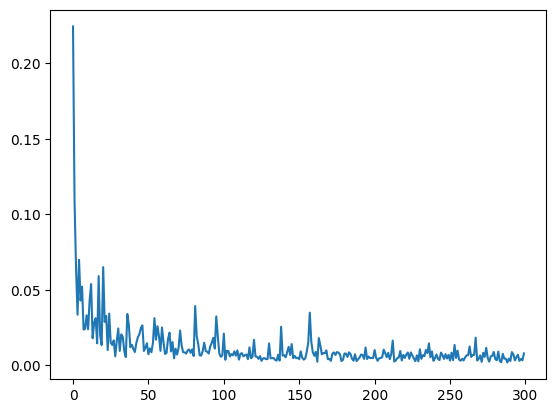

In [10]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [33]:
test_seq = torch.tensor(sequences[0]).float()
test_seq = (test_seq - mean) / std #Normalizamos usando mean y std calculados al entrenar
test_seq = test_seq.unsqueeze(0).to(device)

#Hacemos la prediccion
with torch.no_grad():
    predicted_point = model(test_seq)

predicted_value = (predicted_point.item() * std) + mean #Desnormalizamos la predicción para interpretarla
real_value = (next_points[0] * std) + mean #También desnormalizamos el valor real para compararlo correctamente

print("Predicción (dato siguiente):", predicted_value)
print("Dato siguiente real:", real_value)


Predicción (dato siguiente): tensor(1289.0795)
Dato siguiente real: tensor(1204.3940)
